<a href="https://colab.research.google.com/github/fframee/lab/blob/main/Lab9_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


We will use a dataset of pizza, stead and sushi images ([source](https://www.learnpytorch.io/04_pytorch_custom_datasets/))

In [6]:
!unzip -q pizza_steak_sushi.zip

In [7]:
train_dir = "train"
test_dir = "test"

# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

Class names: ['pizza', 'steak', 'sushi']
Class to index mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}
Number of training samples: 225
Number of testing samples: 75
Number of batches in training DataLoader: 8
Number of batches in testing DataLoader: 1


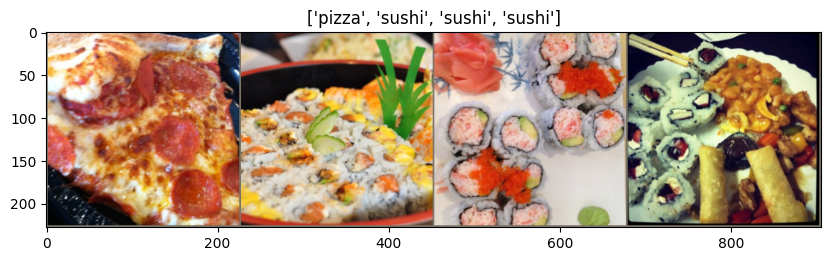

In [8]:
# 1. Define data transformations
import torchvision.transforms as transforms
from torchvision import datasets # Import datasets
from torch.utils.data import DataLoader # Import DataLoader

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize pixel values (ImageNet statistics)
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.4)
])

# 2. Create datasets using ImageFolder
train_data = datasets.ImageFolder(root ='train'  ,
                                                transform = data_transforms) # Write your code here
test_data =  datasets.ImageFolder(root ='test'  ,
                                                transform = data_transforms)# Write your code here

# Get class names and their mapping
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# 3. Create DataLoaders
BATCH_SIZE = 32 # You can experiment with different batch sizes

train_dataloader = DataLoader(dataset=train_data,
                                            batch_size =32,
                                            shuffle=True) # Write your code here

test_dataloader =  DataLoader(dataset=test_data,
                                            batch_size =len(test_data),
                                            shuffle=False)# Write your code here

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

# Let's visualize a sample image and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo normalization
    inp = np.clip(inp, 0, 1) # Clip pixel values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [9]:
class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()
        # Write your code here
        self.conv1 = nn.Conv2d(3, 6 , kernel_size=5)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2 )
        # Added layers
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Fully connected layers
        # Calculate input features for FC1: 16 * 53 * 53 = 44944
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        # Write your code here
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        # Added layers
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        # Flatten
        x = self.flatten(x)
        # Fully connected layers
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)


        return x


# Instantiate LeNet model
lenet_model = LeNet(num_classes=3)

In [10]:
lenet_model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [12]:
# Training loop function (to be reused)
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    print(f"\n--- Training {model.__class__.__name__} for {num_epochs} epochs ---")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Training phase
        model.train() # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            # Write your code here
            # 1. Move inputs and labels to device
            x = inputs.to(device)
            y = labels.to(device)

            # 2. Zero the gradient
            optimizer.zero_grad()

            # 3. Make predictions
            y_pred = model(x)

            # 4. Calculate the loss
            loss = criterion(y_pred, y)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update model's parameters
            optimizer.step()

            # Calculate total loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(y_pred.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_acc = train_correct / train_total
        results["train_loss"].append(epoch_train_loss)
        results["train_acc"].append(epoch_train_acc)

        # Evaluation phase
        model.eval() # Set model to evaluation mode
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad(): # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_dataloader.dataset)
        epoch_test_acc = test_correct / test_total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")
    return results

In [13]:
# Instantiate LeNet model
lenet_model = LeNet(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
print(lenet_model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [14]:
# Train the LeNet model
lenet_model.to(device)
lenet_results = train_model(lenet_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10)


--- Training LeNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.1447, Train Acc: 0.3600 | Test Loss: 1.0533, Test Acc: 0.4533
Epoch 2/10 - Train Loss: 0.9802, Train Acc: 0.5244 | Test Loss: 1.1559, Test Acc: 0.4000
Epoch 3/10 - Train Loss: 0.8986, Train Acc: 0.5822 | Test Loss: 1.0007, Test Acc: 0.5733
Epoch 4/10 - Train Loss: 0.7870, Train Acc: 0.6533 | Test Loss: 1.0446, Test Acc: 0.4533
Epoch 5/10 - Train Loss: 0.6614, Train Acc: 0.7156 | Test Loss: 1.0272, Test Acc: 0.5733
Epoch 6/10 - Train Loss: 0.5932, Train Acc: 0.7289 | Test Loss: 1.0612, Test Acc: 0.4533
Epoch 7/10 - Train Loss: 0.5278, Train Acc: 0.7956 | Test Loss: 0.9938, Test Acc: 0.5600
Epoch 8/10 - Train Loss: 0.3737, Train Acc: 0.8622 | Test Loss: 1.0727, Test Acc: 0.5600
Epoch 9/10 - Train Loss: 0.4388, Train Acc: 0.8267 | Test Loss: 1.2030, Test Acc: 0.5200
Epoch 10/10 - Train Loss: 0.4316, Train Acc: 0.8622 | Test Loss: 1.1102, Test Acc: 0.4933


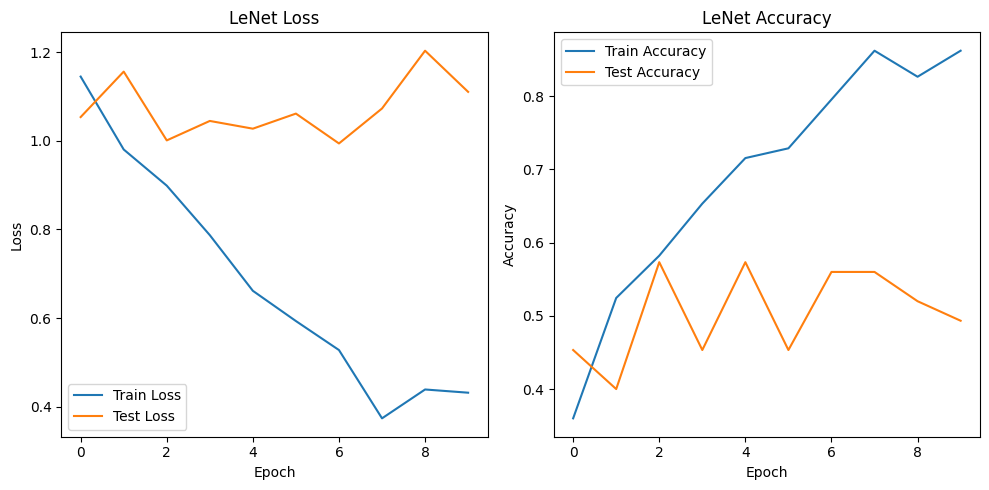

In [15]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 1:
1. How did the LeNet model perform on the test set? What was its final test accuracy?
   * **Your Answer:** จากกราฟและผลลัพธ์ที่แสดง LeNet model มีประสิทธิภาพบน test set ที่ไม่ค่อยดีนัก โดยมีความแม่นยำ (Test Acc) อยู่ที่ประมาณ 49.33% ใน epoch สุดท้าย ซึ่งต่ำกว่าความแม่นยำบน training set (Train Acc) ที่สูงถึง 86.22% แสดงให้เห็นว่า model อาจเกิด overfitting กับข้อมูล training set

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [16]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)
print("Original EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s] 


Original EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [17]:
efficientnet_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [18]:
# 2. Freeze all parameters in the feature extractor part
#### Write your code here
for param in efficientnet_model.features.parameters():
  param.requires_grad = False

# 3. Modify the classifier head for 3 classes
# EfficientNet's classifier is a sequential block, typically with a dropout and a linear layer.
# We need to replace the last linear layer.
# 3.1 Get input features to the last linear layer


# 3.2 Change the head (the classifier) of the model
#     Use nn.Sequential() to create a small model with a sequence of layers
efficientnet_model.classifier[1] = nn.Linear(1280, 3)

efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)


Modified EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [19]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
classifier.1.weight
classifier.1.bias


In [20]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss() # Write your code here
optimizer_tl = optim.Adam(params_to_update, lr=0.001) # Write your code here

In [21]:
# 5. Train the transfer learning model
efficientnet_results = train_model(efficientnet_model, train_dataloader, test_dataloader, criterion_tl, optimizer_tl, num_epochs=10)


--- Training EfficientNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.0378, Train Acc: 0.4978 | Test Loss: 0.8656, Test Acc: 0.7467
Epoch 2/10 - Train Loss: 0.8422, Train Acc: 0.7200 | Test Loss: 0.7366, Test Acc: 0.8000
Epoch 3/10 - Train Loss: 0.7393, Train Acc: 0.7733 | Test Loss: 0.7164, Test Acc: 0.7600
Epoch 4/10 - Train Loss: 0.6406, Train Acc: 0.8578 | Test Loss: 0.6768, Test Acc: 0.8400
Epoch 5/10 - Train Loss: 0.5552, Train Acc: 0.9067 | Test Loss: 0.5964, Test Acc: 0.8800
Epoch 6/10 - Train Loss: 0.5139, Train Acc: 0.9156 | Test Loss: 0.5307, Test Acc: 0.9067
Epoch 7/10 - Train Loss: 0.4722, Train Acc: 0.9333 | Test Loss: 0.4982, Test Acc: 0.8667
Epoch 8/10 - Train Loss: 0.4334, Train Acc: 0.9156 | Test Loss: 0.4842, Test Acc: 0.9200
Epoch 9/10 - Train Loss: 0.4201, Train Acc: 0.9200 | Test Loss: 0.4728, Test Acc: 0.9200
Epoch 10/10 - Train Loss: 0.3824, Train Acc: 0.9511 | Test Loss: 0.4635, Test Acc: 0.8800


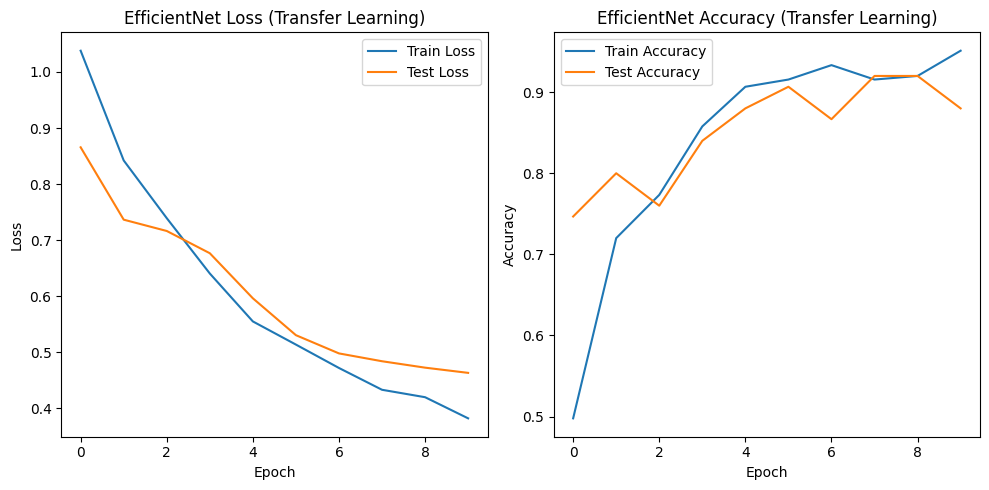

In [22]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1. Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
   * **Your Answer:** จากผลลัพธ์ที่ได้ EfficientNet_B0 ที่ใช้ Transfer Learning มีประสิทธิภาพบน Test Set ดีกว่า LeNet Model ที่ Train จาก Scratch อย่างเห็นได้ชัด EfficientNet_B0 มีความแม่นยำบน Test Set อยู่ที่ประมาณ 88% ใน Epoch สุดท้าย ในขณะที่ LeNet มีความแม่นยำเพียง 49.33% นี่เป็นเพราะ EfficientNet_B0 เป็น Model ที่ซับซ้อนกว่าและถูก Train มาก่อนแล้วบน Dataset ขนาดใหญ่ (ImageNet) ทำให้สามารถเรียนรู้ Feature ที่มีประสิทธิภาพและนำไปใช้กับงานอื่นได้ (Generalizable) ในขณะที่ LeNet ซึ่งเป็น Model ที่ง่ายกว่าและ Train จาก Scratch บน Dataset ขนาดเล็ก มีแนวโน้มที่จะ Overfit กับ Training Data
2. Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
   * **Your Answer:** การ "Freezing" Layers ใน Transfer Learning คือการทำให้ Parameters (Weights และ Biases) ของ Layers เหล่านั้นไม่ถูก Update ระหว่างการ Training โดยปกติจะทำกับ Layers แรกๆ ของ Pre-trained CNNs ซึ่ง Layers เหล่านี้ได้เรียนรู้การดึง Feature พื้นฐาน เช่น ขอบ มุม หรือ Texture จากรูปภาพ การ Freezing Layers เหล่านี้ช่วยรักษา Feature ที่เรียนรู้มาแล้ว ซึ่งมีประโยชน์มากแม้กับ Dataset ขนาดเล็ก ประโยชน์ของการ Freezing Layers ได้แก่:
     * **Training เร็วขึ้น:** เนื่องจาก Update เฉพาะบางส่วนของ Model ทำให้ Training Process เร็วขึ้น
     * **ใช้ Data น้อยลง:** Transfer Learning ที่มีการ Freezing Layers ต้องการ Data น้อยกว่าการ Train Deep Network จาก Scratch เพราะ Model ไม่ต้องเรียนรู้การดึง Feature พื้นฐานใหม่ทั้งหมด
     * **ประสิทธิภาพดีขึ้นบน Dataset ขนาดเล็ก:** การใช้ Feature ที่ Pre-trained มาช่วยให้ Model มีประสิทธิภาพดีขึ้นบน Dataset ขนาดเล็ก ซึ่งหาก Train จาก Scratch อาจทำให้เกิด Overfitting ได้ง่าย
3. What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
   * **Your Answer:** เมื่อ Dataset ใหม่มีความแตกต่างอย่างมากจาก Dataset ที่ใช้ Pre-trained Model (เช่น ภาพทางการแพทย์ vs. ImageNet) อาจเกิดความท้าทายดังนี้:
     * **Feature ไม่ตรงกัน (Feature Mismatch):** Features ที่ Pre-trained Model เรียนรู้จาก ImageNet อาจไม่เกี่ยวข้องโดยตรงหรือเหมาะสมกับ Domain ใหม่ (เช่น ภาพทางการแพทย์ที่มีโครงสร้างและ Pattern ที่แตกต่าง)
     * **ต้อง Fine-tuning เพิ่มเติม:** การ Freezing ทุก Layers อาจไม่เพียงพอ อาจต้องทำ "Fine-tuning" บาง Layers แรกๆ ด้วย เพื่อให้ Model ปรับตัวเข้ากับลักษณะเฉพาะของ Dataset ใหม่ ซึ่งรวมถึงการ Unfreeze บาง Layers และ Train ด้วย Learning Rate ที่น้อยมาก
     * **Domain Adaptation:** อาจต้องใช้เทคนิค Domain Adaptation เพื่อเชื่อมช่องว่างระหว่าง Source Domain (ImageNet) และ Target Domain (ภาพทางการแพทย์)
     * **ความพร้อมของ Labeled Data:** ถึงแม้ Transfer Learning จะช่วยลดความต้องการ Data จำนวนมาก แต่ก็ยังต้องการ Labeled Data ที่เพียงพอสำหรับ Task ใหม่ เพื่อ Fine-tune Model และ Train Classifier Head ใหม่ให้มีประสิทธิภาพ
4. Choose 3 images from the test set. Display the images and show their predicted classes.

In [23]:
# Example of making prediction on an image

x = torch.rand(28, 28, 1)  # an image

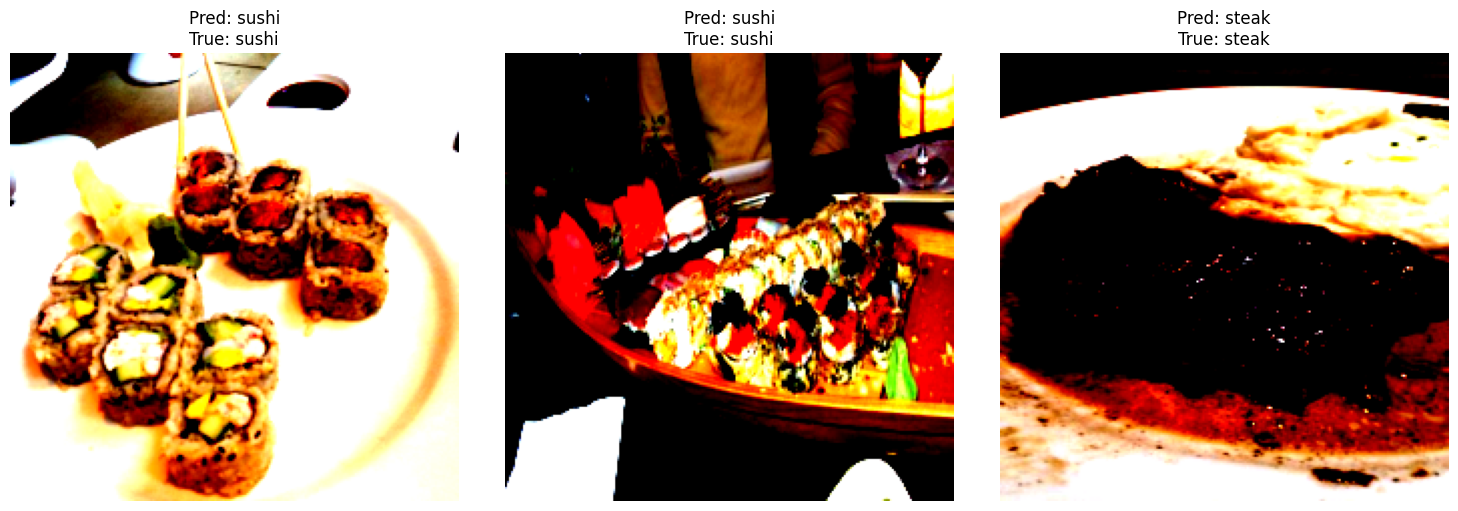

In [27]:
import random
import torch
import matplotlib.pyplot as plt

# helper function for tensor -> image
def imshow(img, title=None):
    img = img.permute(1, 2, 0)  # C x H x W -> H x W x C
    img = img.numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

# Get a batch of test data
test_inputs, test_labels = next(iter(test_dataloader))

# Model to eval mode
efficientnet_model.eval()
efficientnet_model.to(device)

# Random indices
random_indices = random.sample(range(len(test_inputs)), 3)

# Create subplots 1 row x 3 cols
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        image = test_inputs[idx].unsqueeze(0).to(device)
        label = test_labels[idx]

        # Prediction
        output = efficientnet_model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        true_class = class_names[label.item()]

        # Show image
        ax = axes[i]
        img_disp = test_inputs[idx].cpu()  # remove batch
        ax.imshow(img_disp.permute(1, 2, 0).numpy())
        ax.set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
        ax.axis("off")

plt.tight_layout()
plt.show()
